# Bioinformatics of high-mismatch self-targeting spacers
This Notebook generates the following plots:
* Fig. S3A
* Fig. S3B
* Fig. S3C
* Fig. S3D

In [1]:
using DelimitedFiles, Statistics, PyPlot
rc(:svg,fonttype=:none)

using NBInclude
@nbinclude("CRISPRCasdb.ipynb")

## Spacer STS levels

Here we have categorized every spacer in 2,380 genomes based on the level of self-targeting (no self-targeting, high-mismatch, low-mismatch, or exact self-target).

Steps:
1. Download genomes using NCBI Datasets.
2. BLAST CRISPRCasdb spacers against their host genome using very sensitive parameters (task blastn-short, word_size 4, reward 5, penalty -4, perc_identity 60, evalue 1, ungapped).
3. Remove all matches within CRISPR arrays.
4. Categorize every spacer into one of 4 STS levels:
    + 0 = no self-target (or >10 mismatches away)
    + 1 = high-mismatch self-target (4-10 mismatches away)
    + 2 = low-mismatch self-target (1-3 mismatches away)
    + 3 = exact self-target

## Genome STS levels

We have also categorized genomes according to the highest STS level of spacers they carry:
- no self-targeting at all, or few high-mismatch STS (blue)
- many (at least 20) high-mismatch STS (cyan)
- at least 1 low-mismatch STS (orange)
- at least 1 exact STS (red)

In [2]:
genomeinfo = readdlm("STS-bioinformatics/genomeinfo.csv",',') # genome-level information for 2,380 genomes
gbs_dl = readdlm("STS-bioinformatics/dl.txt") # the 2,380 genomes
num_dl = size(genomeinfo,1)

2380

In [3]:
[count(x->x==i, genomeinfo[:,10]) for i in 0:3] # no. of genomes at each STS level

4-element Vector{Int64}:
 919
 701
 260
 500

## Fig. S3A: Spacer STS levels by length

In [4]:
lrange = collect(25:45)
num_l = length(lrange)
spacerSTSlevels_l = zeros(Int,4,num_l)

for i in 1:num_dl
    spacerinfo = readdlm("STS-bioinformatics/spacerinfo/$(gbs_dl[i])_spacerinfo.csv",',')
    for i in 1:num_l
        l = lrange[i]
        inds = findall(x->x==l, spacerinfo[:,11])
        for j in 0:3
            spacerSTSlevels_l[j+1,i] += count(x->x==j, spacerinfo[inds,16])
        end
    end
end

In [5]:
frac_spacerSTSlevels_l = spacerSTSlevels_l./sum(spacerSTSlevels_l,dims=1)

4×21 Matrix{Float64}:
 0.529412   0.446154   0.460993   …  0.993125    0.986828    0.975143
 0.431373   0.5        0.460993      0.00305577  0.00768386  0.00764818
 0.0196078  0.0384615  0.0212766     0.00152788  0.00109769  0.00382409
 0.0196078  0.0153846  0.0567376     0.00229183  0.00439078  0.0133843

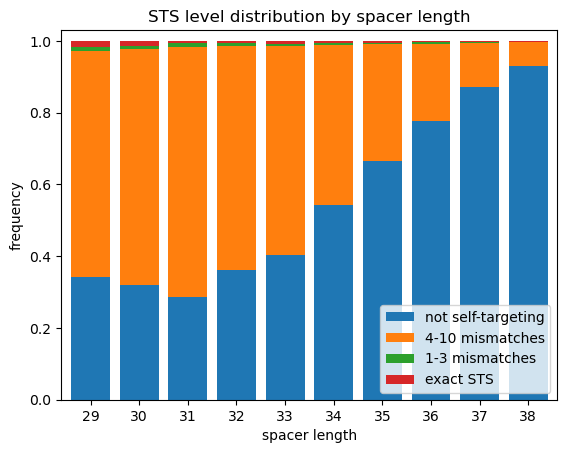

PyObject Text(24.000000000000007, 0.5, 'frequency')

In [6]:
# stacked bar chart

labels = ["not self-targeting", "4-10 mismatches", "1-3 mismatches", "exact STS"]

fig, ax = subplots()

ax.bar(lrange, frac_spacerSTSlevels_l[1,:], label=labels[1])
for i in 1:3
    ax.bar(lrange, frac_spacerSTSlevels_l[1+i,:], bottom=vec(sum(frac_spacerSTSlevels_l[1:i,:],dims=1)), label=labels[1+i])
end

ax.legend(loc="lower right")

xticks(lrange, lrange)
xlim(28.4,38.6)
ylim(0,1.03)

title("STS level distribution by spacer length")
xlabel("spacer length")
ylabel("frequency")

# ax.spines["top"].set_visible(false)
# ax.spines["right"].set_visible(false)

# savefig("STS-level-vs-l.svg",format="svg")

## Fig. S3B

In [7]:
colors = ["C0", "cyan", "orange", "red"]

colors_dl = [colors[genomeinfo[i,10]+1] for i in 1:num_dl];

In [8]:
gbs_cc = readdlm("filtered/gbs_cc_filter.csv",',');

In [9]:
for i in 1:100 # with prophage information
    if genomeinfo[i,4] >= 0 && # with acr information
      genomeinfo[i,10]==2
        taxid = gbs_cc[findfirst(x->x==gbs_dl[i], gbs_cc[:,2]),1]
        println("$i, $(taxid2name[taxid]), $(genomeinfo[i,4]), $(genomeinfo[i,5]), $(genomeinfo[i,10])")
    end
end

9, [Mannheimia] succiniciproducens, 1, 1, 2
57, Clostridium novyi, 0, 1, 2
65, Acidothermus cellulolyticus, 0, 0, 2
68, Shewanella sp. W3-18-1, 1, 1, 2
81, Rhodospirillum centenum, 1, 1, 2


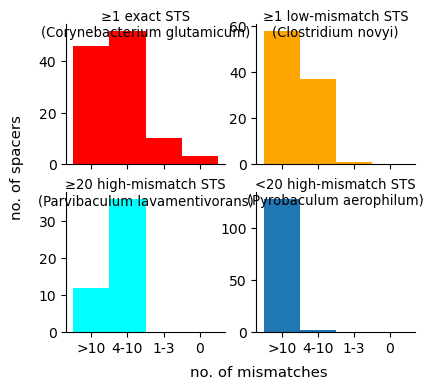

PyObject Text(0, 0.4, 'no. of spacers')

In [10]:
ni = 2
nj = 2

n_dl = [24, 57, 99, 5]

labels = ["<20 high-mismatch STS", "≥20 high-mismatch STS", "≥1 low-mismatch STS", "≥1 exact STS"]

fig, axs = plt.subplots(ni, nj, figsize=(4.5, 4), sharex=true, sharey=false)

for i in 1:ni, j in 1:nj
    n = (i-1)*nj + j
    
    axs[i,j].bar(0:3, genomeinfo[n_dl[n],6:9], width=1, color=colors_dl[n_dl[n]])
    
    axs[i,j].set_xticks(0:3)
    axs[i,j].set_xticklabels([">10","4-10","1-3","0"])
    
    axs[i,j].spines["top"].set_visible(false)
    axs[i,j].spines["right"].set_visible(false)
    
    # subtypes
    subtypes = sort(unique([caslocus2subtype[c] for c in genbank2casloci[gbs_dl[n_dl[n]]]]))
    ststring = join(subtypes,", ")
    
    # species
    taxid = gbs_cc[findfirst(x->x==gbs_dl[n_dl[n]], gbs_cc[:,2]),1]
    name = taxid2name[taxid]
    
    axs[i,j].set_title("$(labels[5-n])\n($name)", loc="center", y=0.85, fontsize=9.5)
end

fig.text(0.4,0,"no. of mismatches",fontsize=10.7)
fig.text(0,0.4,"no. of spacers",rotation="vertical",fontsize=10.7)

# savefig("STS-level-examples.svg",format="svg")

## Fig. S3C: Genome STS level by prophage presence

In [11]:
inds0 = findall(x->x==0, genomeinfo[:,5]) # no prophages
counts0 = [count(x->x==i, genomeinfo[inds0,10]) for i in 0:3]

inds1 = findall(x->x==1, genomeinfo[:,5]) # has prophages
counts1 = [count(x->x==i, genomeinfo[inds1,10]) for i in 0:3];

In [12]:
[counts0 counts1]

4×2 Matrix{Int64}:
 26  12
 14  21
  1   5
  6  15

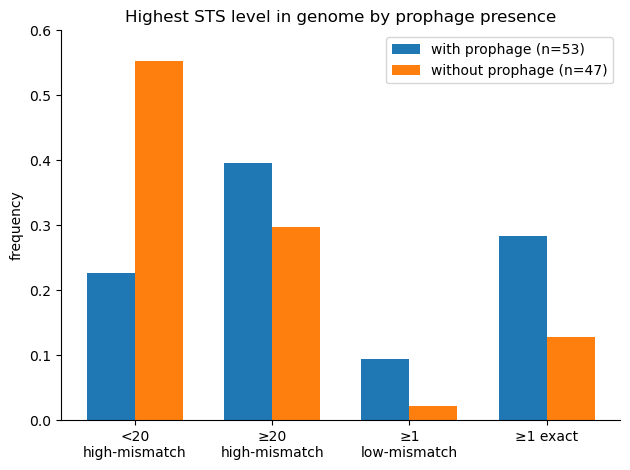

In [13]:
fig, ax = subplots()

width = 0.35  # the width of the bars
labels = ["<20\nhigh-mismatch", "≥20\nhigh-mismatch", "≥1\nlow-mismatch", "≥1 exact"]

n1 = sum(counts1)
n0 = sum(counts0)

ax.bar(collect(0:3) .- width/2, counts1/n1, width, label="with prophage (n=$n1)")
ax.bar(collect(0:3) .+ width/2, counts0/n0, width, label="without prophage (n=$n0)")

ax.set_title("Highest STS level in genome by prophage presence")
ax.set_ylabel("frequency")
ax.set_xticks(0:3)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0,0.6)

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)

fig.tight_layout()

# savefig("STS-level-by-prophage.svg",format="svg")

## Fig. S3D: Genome STS level by acr presence

In [14]:
inds0 = findall(x->x==0, genomeinfo[:,4]) # no acrs
counts0 = [count(x->x==i, genomeinfo[inds0,10]) for i in 0:3]

inds1 = findall(x->x==1, genomeinfo[:,4]) # has acrs
counts1 = [count(x->x==i, genomeinfo[inds1,10]) for i in 0:3];

In [15]:
[counts0 counts1]

4×2 Matrix{Int64}:
 112  532
  41  436
  20  161
  40  296

In [16]:
# writedlm("gbs_acr.txt",gbs_dl[inds1])

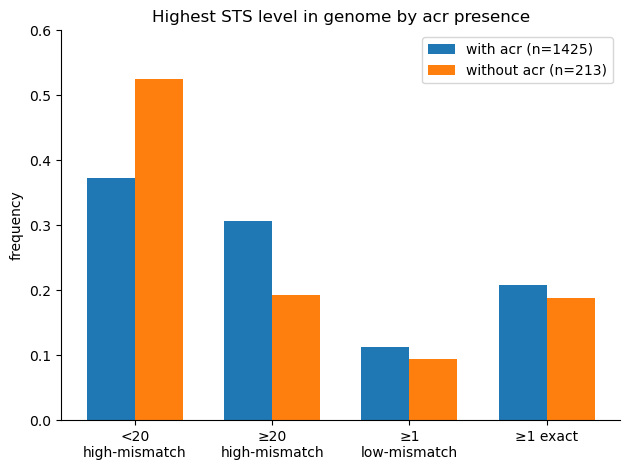

In [17]:
fig, ax = subplots()

width = 0.35  # the width of the bars
labels = ["<20\nhigh-mismatch", "≥20\nhigh-mismatch", "≥1\nlow-mismatch", "≥1 exact"]

n1 = sum(counts1)
n0 = sum(counts0)

ax.bar(collect(0:3) .- width/2, counts1/n1, width, label="with acr (n=$n1)")
ax.bar(collect(0:3) .+ width/2, counts0/n0, width, label="without acr (n=$n0)")

ax.set_title("Highest STS level in genome by acr presence")
ax.set_ylabel("frequency")
ax.set_xticks(0:3)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0,0.6)

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)

fig.tight_layout()

# savefig("STS-level-by-acr.svg",format="svg")